### Network model of elderly home

Guido Vaessen () and Joos Akkerman (11304723)


Report for Introduction to Computational Science

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#### Initialize nurse class

In [2]:
class Worker(object):
    
    def __init__(self, id, status):
        self.id   = id
        self.status = status
        self.connections_clients = []
        self.connections_workers  = []
        
        
    def __str__(self):
        return f'Worker {self.id}, sick: {self.sick}, nurses: {self.connections_clients}, colleague connections: {self.connections_workers}'

#### Initialize client class

In [3]:
class Client(object):
    
    def __init__(self, id, status):
        self.id   = id
        self.status = status
        self.connections_clients = []
        self.connections_workers  = []
        
    def __str__(self):
        return f'Client {self.id}, sick: {self.sick}, nursed by: {self.connections_workers}, client connections with: {self.connections_clients}'

#### Initialize network class

In [4]:
class Network(object):
    
    def __init__(self, id, n_workers, n_clients, clients_to_clients, workers_to_clients):
        self.id        = id
        self.workers   = []
        self.clients   = []
        self.all_I     = []
        self.n_workers = n_workers
        self.n_clients = n_clients
        self.clients_to_clients = clients_to_clients
        self.workers_to_clients = workers_to_clients
        
        # metrics for network
        self.avg_degree    = 0
        self.cluster_coeff = 0
        self.diameter      = 0
        self.degree_centr  = 0
        self.between_centr = 0
        self.close_centr   = 0
        
        
    def init_workers_clients(self):
        """
        Initializes workers and clients
        """
        for worker in range(self.n_workers):
            self.workers += [Worker(worker, 'S')]

        for client in range(self.n_clients):
            self.clients += [Client(client, 'S')]
    
    def connect_workers_clients(self):
        """
        Connects workers and clients
        """
        # connect workers to each other        
        for worker in self.workers:
            for colleague in self.workers:
                if colleague != worker:
                    worker.connections_workers += [colleague]
                    
                    
        # connect clients to each other    
        for client in self.clients:
            for other_client in self.clients:
                if other_client != client:
                    if np.random.random() < self.clients_to_clients/n_clients:
                        client.connections_clients += [other_client]
                        
        # connect workers to clients    
        for client in self.clients:
            worker_connections = list(np.random.choice(self.workers, size=self.workers_to_clients, replace=False))
            client.connections_workers += worker_connections
            for worker in worker_connections:
                worker.connections_clients += [client]
        
        
    def __str__(self):
        return f'Network {self.id}, n of workers: {len(self.workers)}, n of clients: {len(self.clients)}.'

#### Initialize population

In [5]:
def init_network(id, n_workers, n_clients, clients_to_clients, workers_to_clients):
    """
    Initializes network object and worker and client objects
    """
    network = Network(1, n_workers, n_clients, clients_to_clients, workers_to_clients)
    
    # create worker and client nodes
    network.init_workers_clients()
    
    # connect worker and client nodes
    network.connect_workers_clients()
    
    return network

#### Create graph object, inject data from network object

In [6]:
def upload_network(network):
    G = nx.Graph()
    node_color_map = []
    edge_color_map = []

    # add nodes to graph
    for worker in network.workers:
        G.add_node(f'w{worker.id}')
        if worker.status == 'I':
            node_color_map += ['red']
        else:
            node_color_map += ['blue']

    for client in network.clients:
        G.add_node(f'c{client.id}')
        if client.status == 'I':
            node_color_map += ['red']
        else:
            node_color_map += ['green']

    # add edges between nodes
    for worker in network.workers:
        for colleague in worker.connections_workers:
            G.add_edge(f'w{worker.id}', f'w{colleague.id}')
            edge_color_map += ['black']

    for client in network.clients:

        for worker in client.connections_workers:
            G.add_edge(f'c{client.id}', f'w{worker.id}')
            edge_color_map += ['red']

        for otherclient in client.connections_clients:
            G.add_edge(f'c{client.id}', f'c{otherclient.id}')
            edge_color_map += ['orange']
    
    return G, node_color_map

In [7]:
def update_network_metrics(G, network):
    """
    Updates network metrics
    """
    network.avg_degree    = nx.average_degree_connectivity(G)
    network.cluster_coeff = nx.algorithms.cluster.average_clustering(G)
    network.diameter      = nx.diameter(G)
    network.degree_centr  = nx.algorithms.centrality.degree_centrality(G)
    network.between_centr = nx.algorithms.centrality.betweenness_centrality(G)
    network.close_centr   = nx.algorithms.centrality.closeness_centrality(G)

In [8]:
def reset_network(network):
    """
    Set population back to initial values
    """
    for indiv in network.all_I:
        indiv.status = 'S'
    network.all_I = []
    
    G, node_color_map = upload_network(network)
    
    return G, node_color_map

#### Create First Network

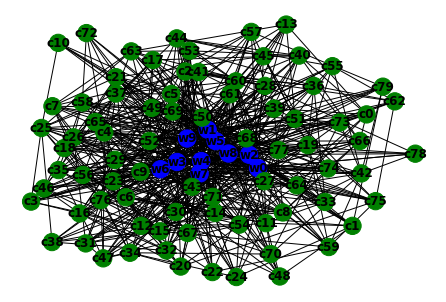

In [26]:
# set population parameters
n_workers = 10
n_clients = n_workers*8
clients_to_clients = 4
workers_to_clients = 4

def create_network(n_workers, n_clients, clients_to_clients, workers_to_clients):

    # initialize network and draw
    network = init_network(1, n_workers, n_clients, clients_to_clients, workers_to_clients)
    G, node_color_map = upload_network(network)
    update_network_metrics(G, network)

    # print(network.avg_degree)
    nx.draw(G, with_labels=True, node_color=node_color_map, font_weight='bold')
    
    return network, G
    
network, G = create_network(n_workers, n_clients, clients_to_clients, workers_to_clients)

#### Propagate disease through population

Fraction infected = 0.97


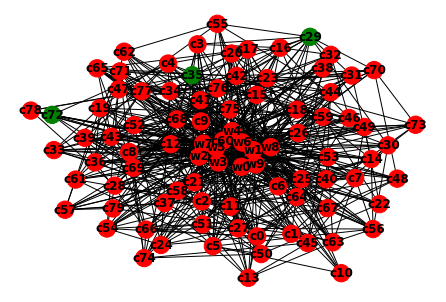

In [27]:
# Disease parameters:
beta_wc = 0.5
beta_ww = 0.1
beta_cc = 0.1

# reset population
G, node_color_map = reset_network(network)

# randomly infect one worker
sick_worker = np.random.choice(network.workers)
sick_worker.status = 'I'
network.all_I += [sick_worker]


# let infection spread through population
new_disease = [sick_worker]
while len(new_disease) != 0:
    
    got_infected = []
    for indiv in new_disease:
        
        # change beta based on class individual
        beta_w = beta_ww
        beta_c = beta_wc
        if indiv in network.clients:
            beta_w = beta_wc
            beta_c = beta_cc
            
        for worker in indiv.connections_workers:
            if np.random.uniform() < beta_w and worker.status != 'I':
                worker.status = 'I'
                network.all_I += [worker]
                got_infected += [worker]
        
        for client in indiv.connections_clients:
            if np.random.uniform() < beta_c and client.status != 'I':
                client.status = 'I'
                network.all_I += [client]
                got_infected += [client]
    
    # update new disease list
    new_disease = got_infected

G, node_color_map = upload_network(network)
update_network_metrics(G, network)
nx.draw(G, with_labels=True, node_color=node_color_map, font_weight='bold')

print(f'Fraction infected = {round(len(network.all_I)/(len(network.workers)+len(network.clients)),2)}')